In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

**Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи

In [42]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(10)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0
5,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,380.0,POS,0,0.0
6,01/10/2017,1,5814,NaN,810,10OCT17:00:00:00,378.0,POS,0,0.0
7,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,199.0,POS,0,0.0
8,01/10/2017,1,5814,NaN,810,11OCT17:00:00:00,400.0,POS,0,0.0
9,01/07/2017,1,5411,NaN,810,26JUL17:00:00:00,598.0,POS,0,0.0


In [43]:
raw_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [44]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


In [45]:
# Самые популярные MCC

raw_df.groupby('MCC').count()[['cl_id']].sort_values('cl_id', ascending=False).head(5)

,cl_id
MCC,
5411,121640
6011,54382
5814,41351
5812,30027
5499,27237


In [46]:
# Самые популярные trx_category

raw_df.groupby('trx_category').count()[['cl_id']].sort_values('cl_id', ascending = False).head(5)

,cl_id
trx_category,
POS,416425
DEPOSIT,21216
WD_ATM_ROS,19104
WD_ATM_PARTNER,9948
C2C_IN,7306


In [47]:

def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df
    
    

def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    return dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()

# transaction_by_day_count(raw_df)


In [48]:
#Активность клиентов по дням недели

day_df = transaction_by_day_count(raw_df)
# day_df.groupby("day_of_transaction").count()
day_df.sum()


day_of_transaction
cl_id    25561672.0
day_0       62114.0
day_1       65927.0
day_2       68509.0
day_3       69485.0
day_4       71458.0
day_5       78993.0
day_6       74027.0
dtype: float64

In [ ]:
#больше всего кленты активны в субботу

In [49]:
hour_df = transaction_by_hour_count(raw_df)
del hour_df['cl_id']
hour_df.sum()

hour_of_transaction
00    432913.0
01       252.0
02       350.0
03       456.0
04       660.0
05       981.0
06      1315.0
07      1983.0
08      2699.0
09      3635.0
10      4088.0
11      4681.0
12      4707.0
13      4843.0
14      4397.0
15      4120.0
16      3848.0
17      3816.0
18      3659.0
19      2704.0
20      1797.0
21      1268.0
22       850.0
23       491.0
dtype: float64

In [10]:
# больше всего клиенты активны с 9 до 6

In [18]:
# общая сумма транзакций по каждой из trx_category

In [50]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [51]:
agg_trx=get_aggregated_df(raw_df,'sum','trx_category').reset_index()
agg_trx.head(20)

trx_category,cl_id,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS
0,0,0.0,0.00,36562.00,0.0,0.00,20000.0,7821.00,0.0,0.0,0.0
1,1,0.0,0.00,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,50000.0
2,5,13990.0,0.00,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,66500.0
3,9,0.0,296950.00,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,435000.0
4,10,0.0,10000.00,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,422300.0
5,11,0.0,0.00,0.00,0.0,0.00,182000.0,245747.14,0.0,0.0,0.0
6,14,0.0,152700.00,0.00,0.0,0.00,0.0,258990.17,0.0,0.0,37000.0
7,20,0.0,0.00,0.00,0.0,0.00,215000.0,222308.09,0.0,0.0,0.0
8,21,2777.0,4001.00,0.00,0.0,0.00,112000.0,220103.65,0.0,0.0,0.0
9,22,0.0,0.00,0.00,0.0,500.00,122600.0,110267.00,3000.0,9900.0,3500.0


In [84]:
agg_count_trx_category=get_aggregated_df(raw_df,'count','trx_category').reset_index()
agg_count_trx_category.head()

trx_category,cl_id,trx_category_count_BACK_TRX,trx_category_count_C2C_IN,trx_category_count_C2C_OUT,trx_category_count_CASH_ADV,trx_category_count_CAT,trx_category_count_DEPOSIT,trx_category_count_POS,trx_category_count_WD_ATM_OTHER,trx_category_count_WD_ATM_PARTNER,trx_category_count_WD_ATM_ROS
0,0,0,0,1,0,0,1,3,0,0,0
1,1,0,0,0,0,0,2,101,0,0,1
2,5,1,0,8,0,0,4,111,2,2,14
3,9,0,3,0,0,0,1,29,0,1,5
4,10,0,1,19,0,3,24,374,0,3,39


In [52]:
raw_df['channel_type'] =raw_df.channel_type.fillna(value = 'nothing')

raw_grouped=raw_df[['cl_id', 'amount', 'target_flag', 'channel_type']].groupby(['cl_id','target_flag', 'channel_type']).sum().fillna(0).reset_index()
raw_grouped.head()

,cl_id,target_flag,channel_type,amount
0,0,0,nothing,64383.00
1,1,0,nothing,267578.04
2,5,1,nothing,546369.13
3,9,0,nothing,849315.09
4,10,0,nothing,1124343.99


In [53]:
df_grouped=raw_grouped.merge(agg_trx, how = 'left', on = 'cl_id')
df_grouped.head(10)

,cl_id,target_flag,channel_type,amount,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS
0,0,0,nothing,64383.00,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,0.0,0.0,0.0
1,1,0,nothing,267578.04,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,50000.0
2,5,1,nothing,546369.13,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,66500.0
3,9,0,nothing,849315.09,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,435000.0
4,10,0,nothing,1124343.99,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,422300.0
5,11,0,nothing,427747.14,0.0,0.0,0.00,0.0,0.00,182000.0,245747.14,0.0,0.0,0.0
6,14,1,nothing,448690.17,0.0,152700.0,0.00,0.0,0.00,0.0,258990.17,0.0,0.0,37000.0
7,20,0,nothing,437308.09,0.0,0.0,0.00,0.0,0.00,215000.0,222308.09,0.0,0.0,0.0
8,21,0,nothing,338881.65,2777.0,4001.0,0.00,0.0,0.00,112000.0,220103.65,0.0,0.0,0.0
9,22,0,nothing,249767.00,0.0,0.0,0.00,0.0,500.00,122600.0,110267.00,3000.0,9900.0,3500.0


In [55]:
# общая сумма транзакции по основным вылютам 

raw_grouped_cur=raw_df[[ 'amount', "currency"]].groupby([ "currency"]).sum().fillna(0).reset_index().sort_values('amount', ascending=False)
raw_grouped_cur.head(10)

raw_grouped_cur["percent"] = (raw_grouped_cur.amount/raw_grouped_cur.amount.sum()*100).apply(round)
raw_grouped_cur.head(5)

,currency,amount,percent
44,810,2.572996e+09,92
37,704,1.367180e+08,5
17,360,7.193555e+07,3
21,410,1.260942e+07,0
19,392,1.710582e+06,0


In [56]:
# 92% - рубль
# 5% - донг
# 3% - рупия

# Доллара совсем не видно  - его доля очень маленькая
raw_grouped_cur[raw_grouped_cur.currency == 840]

,currency,amount,percent
46,840,282144.05,0


/Users/erik/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/erik/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/erik/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/erik/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE

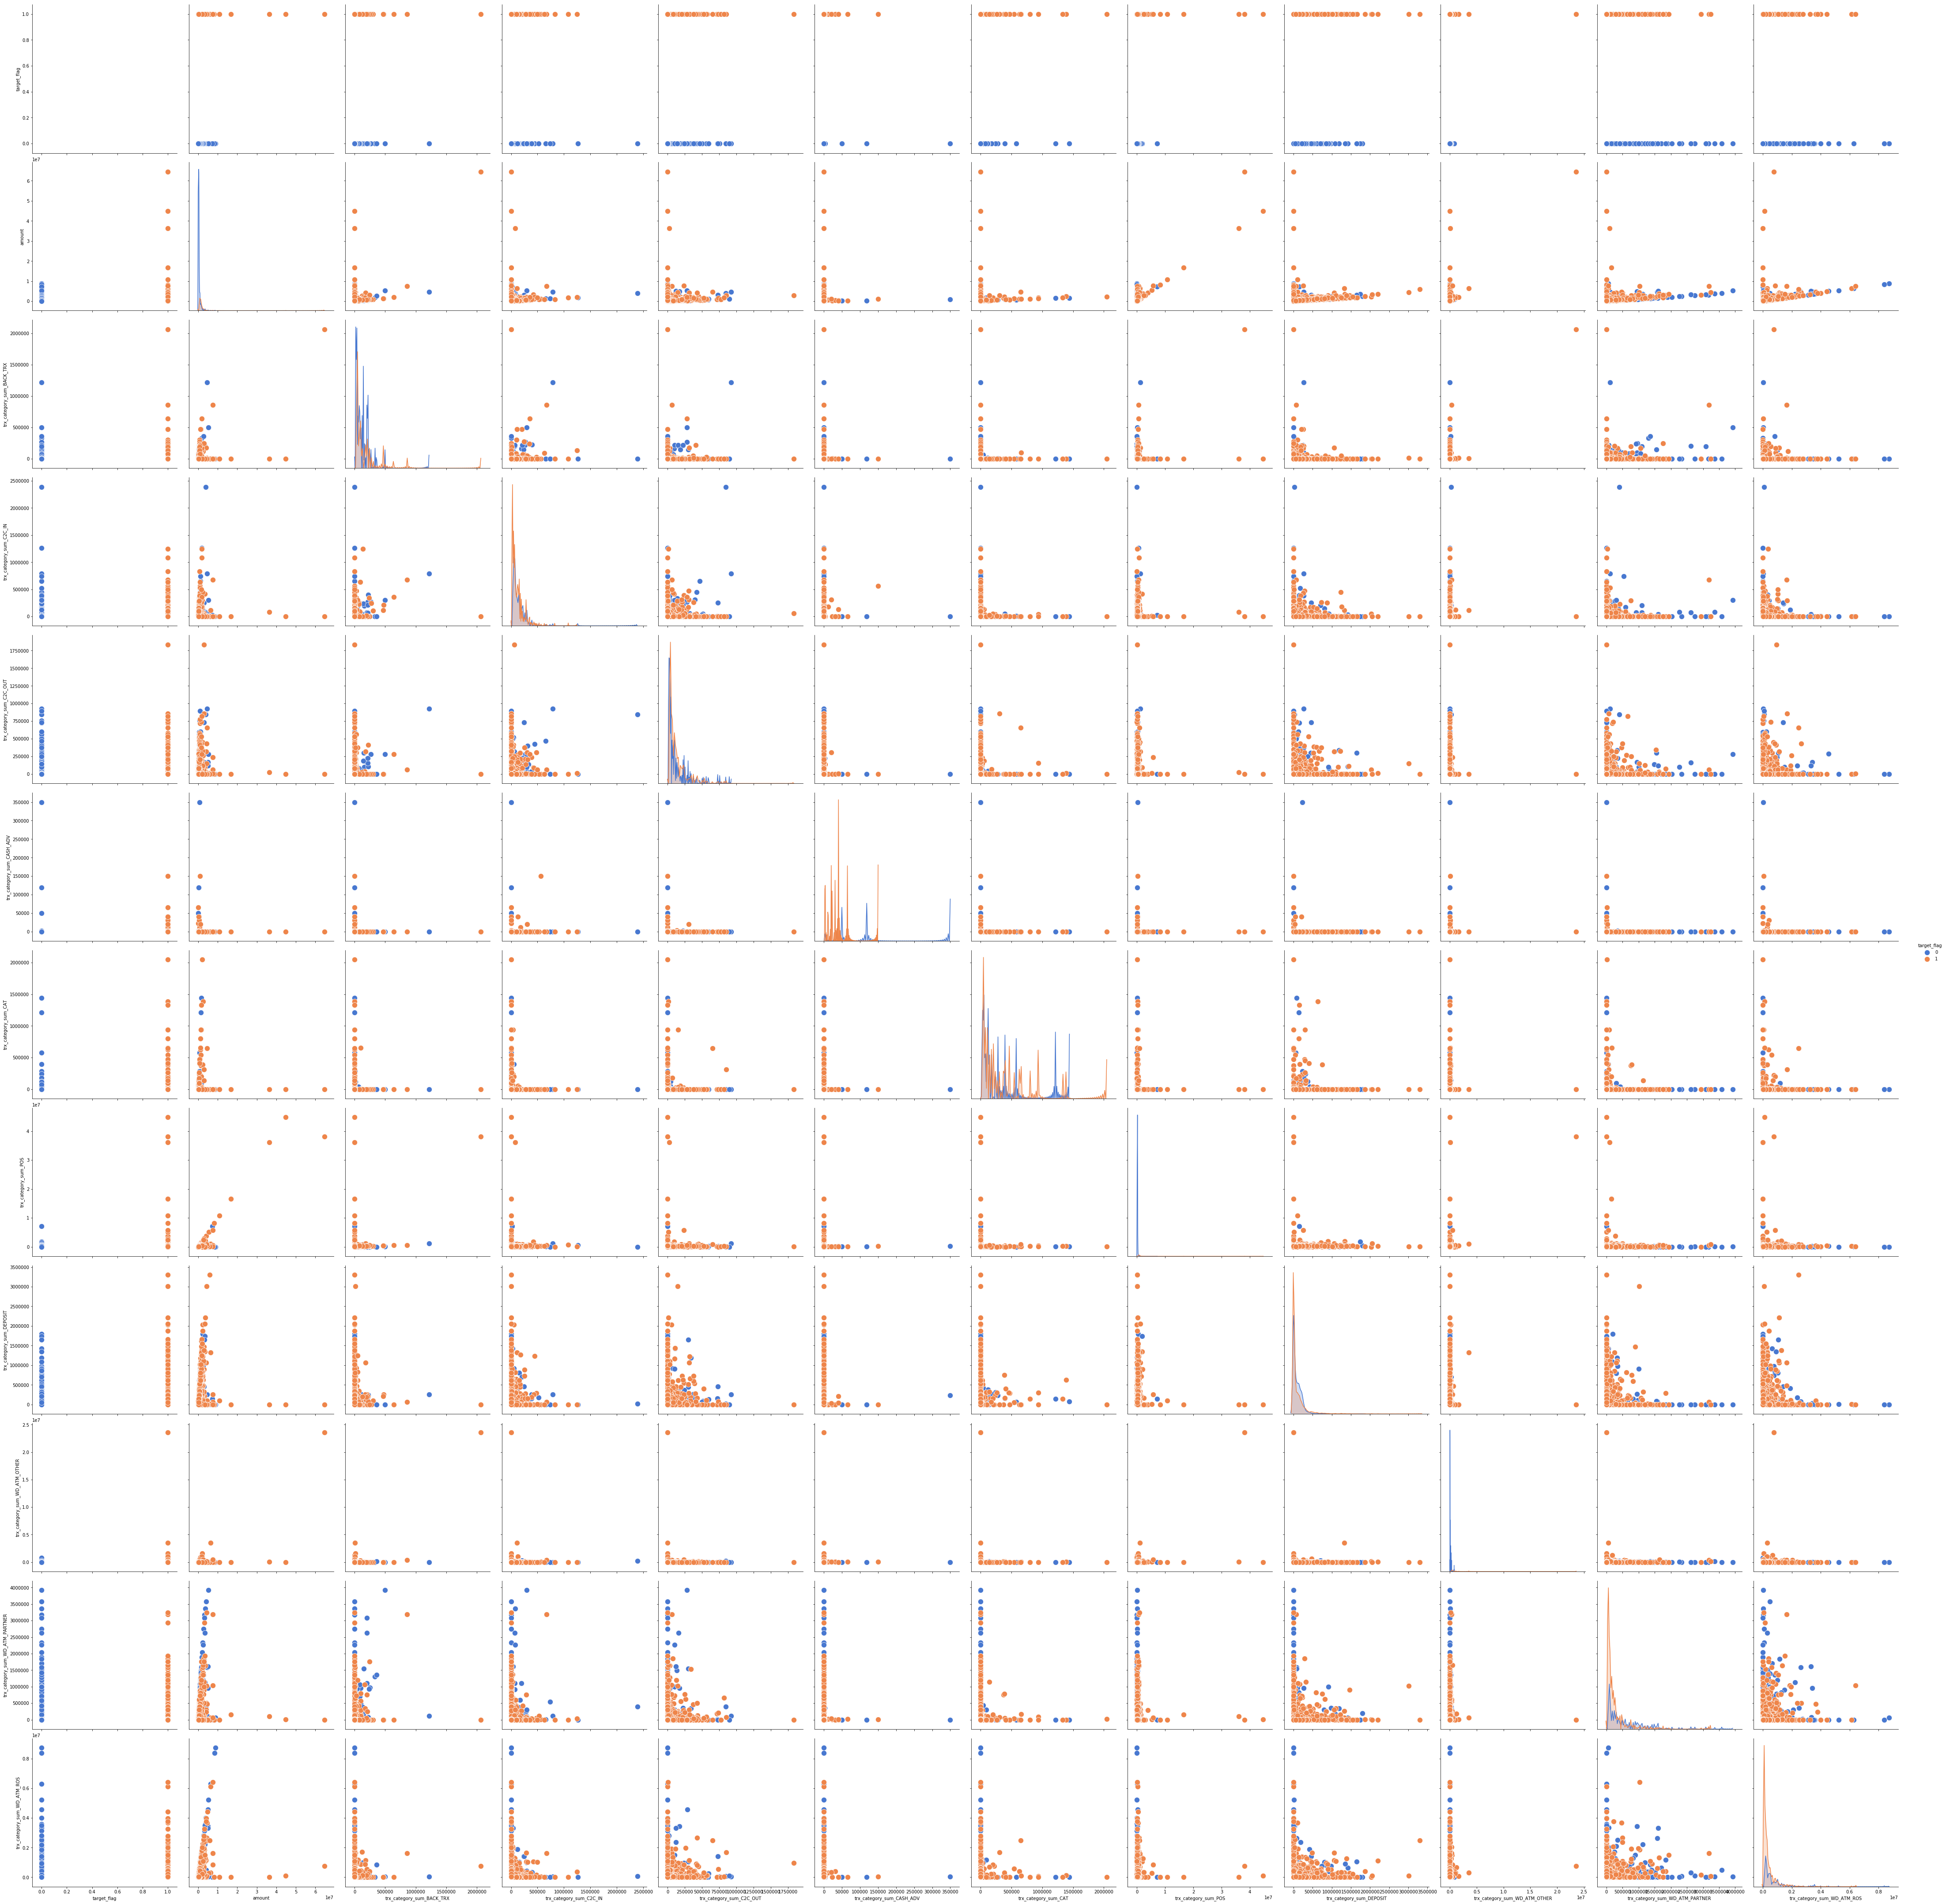

In [28]:
sns.pairplot(data=df_grouped[['target_flag',  'channel_type', 'amount', 'trx_category_sum_BACK_TRX','trx_category_sum_C2C_IN',"trx_category_sum_C2C_OUT", "trx_category_sum_CASH_ADV" , "trx_category_sum_CAT" , "trx_category_sum_POS" , "trx_category_sum_DEPOSIT" , "trx_category_sum_WD_ATM_OTHER" , "trx_category_sum_WD_ATM_PARTNER", "trx_category_sum_WD_ATM_ROS" ]], hue='target_flag', palette = 'muted',
                 size=5.,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=150) )


In [ ]:
#Наблюдаем что очень сильно заметно что ушли те клиенты у которых суммы транзакций больше 
#в категориях trx_category_WD_ATM_PARTNER/ROS/other. Проверяем это


In [57]:
new_data = df_grouped.groupby(["target_flag"]).sum().reset_index()

new_data

,target_flag,cl_id,amount,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS
0,0,14325573,1.035375e+09,10956092.96,43592868.53,30926064.28,524763.16,5811950.19,2.059163e+08,3.024480e+08,6468331.17,164271300.0,264459850.0
1,1,11236099,1.772122e+09,13663080.67,56304281.36,57148814.51,388061.78,16790909.42,2.768296e+08,7.106139e+08,68312289.81,168446450.0,403624650.0


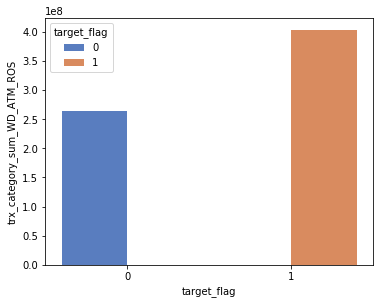

In [58]:
plt.figure(figsize=(20,10))
plt.subplot(2, 3, 2)
sns.barplot(x='target_flag',y='trx_category_sum_WD_ATM_ROS',hue ="target_flag" ,data=new_data,palette='muted')
plt.show()

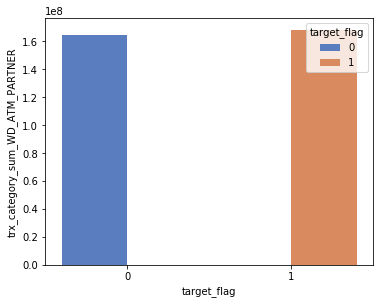

In [59]:
plt.figure(figsize=(20,10))
plt.subplot(2, 3, 2)
sns.barplot(x='target_flag',y='trx_category_sum_WD_ATM_PARTNER',hue ="target_flag" ,data=new_data,palette='muted')
plt.show()

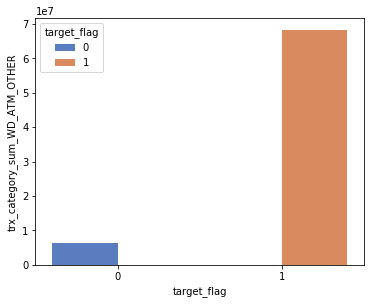

In [60]:
plt.figure(figsize=(20,10))
plt.subplot(2, 3, 2)
sns.barplot(x='target_flag',y='trx_category_sum_WD_ATM_OTHER',hue ="target_flag" ,data=new_data,palette='muted')
plt.show()

In [45]:
#Можем подтвердить вывод что основной отток клиентов связан с тем что они снимают деньги в других банкоматах, видимо 
#проблема в их неудобном расположении

# Обязательная часть к дз 4

In [64]:
#Берем данные для обучения модели треин и тест

test = np.random.choice(df_grouped.cl_id.unique(), size=1000, replace=False)
test_set = set(cl_ids_test)


# данные для обучения
transactions_train = df_grouped[~df_grouped.cl_id.isin(test_set)].copy()
print("Count in train: ", len(transactions_train))
# данные для теста
transactions_test = df_grouped[df_grouped.cl_id.isin(test_set)].copy()
print("Count in test: ", len(transactions_test))

X_test = transactions_test.drop(['cl_id','target_flag',"amount", "channel_type"], axis=1)
y_test = transactions_test['target_flag']

X_test.head()
y_test.head()

X_train = transactions_train.drop(['cl_id','target_flag',"amount", "channel_type"], axis=1)
y_train = transactions_train['target_flag']



cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

X_train.head()


Count in train:  4000
Count in test:  1000


,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS
0,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,0.0,0.0,0.0
1,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,50000.0
2,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,66500.0
3,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,435000.0
4,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,422300.0


In [78]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0).fit(X_train[cols], y_train)
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

y_test_predict = clf.predict_proba(X_test[cols])[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Train:  1.0
Test:  0.76


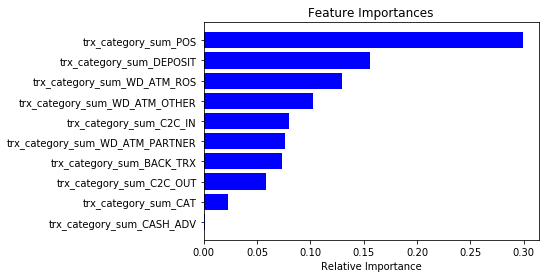

In [79]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
#Посмотрим на модель в которую будут включены только те данные где имели место снятия налички из банкоматов других банков

In [101]:
df_grouped_count=df_grouped.merge(agg_count_trx_category, how = 'left', on = 'cl_id')
df_grouped_count.head()

df_grouped_WD_ATM_OTHER=df_grouped_count[df_grouped_count['trx_category_count_WD_ATM_OTHER']>=1]
df_grouped_WD_ATM_OTHER.head()

,cl_id,target_flag,channel_type,amount,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,...,trx_category_count_BACK_TRX,trx_category_count_C2C_IN,trx_category_count_C2C_OUT,trx_category_count_CASH_ADV,trx_category_count_CAT,trx_category_count_DEPOSIT,trx_category_count_POS,trx_category_count_WD_ATM_OTHER,trx_category_count_WD_ATM_PARTNER,trx_category_count_WD_ATM_ROS
2,5,1,nothing,546369.13,13990.0,0.0,33878.38,0.0,0.0,130000.0,...,1,0,8,0,0,4,111,2,2,14
9,22,0,nothing,249767.00,0.0,0.0,0.00,0.0,500.0,122600.0,...,0,0,0,0,2,8,45,1,2,1
12,25,1,nothing,1471400.00,0.0,125000.0,0.00,0.0,0.0,0.0,...,0,2,0,0,0,0,7,1,0,2
15,31,1,nothing,449867.76,9900.0,0.0,0.00,0.0,0.0,0.0,...,1,0,0,0,0,0,99,1,5,1
16,32,1,nothing,232963.00,0.0,48000.0,13000.00,0.0,0.0,0.0,...,0,4,2,0,0,0,116,4,3,4


In [100]:
new_df_grouped_WD_ATM_OTHER.shape

(1239, 24)

In [111]:
cl_ids_test = np.random.choice(new_df_grouped_WD_ATM_OTHER.cl_id.unique(), size=250, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [112]:
# данные для обучения
transactions_train = new_df_grouped_WD_ATM_OTHER[~new_df_grouped_WD_ATM_OTHER.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# данные для теста
transactions_test = new_df_grouped_WD_ATM_OTHER[new_df_grouped_WD_ATM_OTHER.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  989
Total transactions in test dataset:  250


In [119]:
#Test
X_test = transactions_test.drop(['cl_id','target_flag',"amount", "channel_type"], axis=1)
y_test = transactions_test['target_flag']


#Train
X_train = transactions_train.drop(['cl_id','target_flag',"amount", "channel_type"], axis=1)
y_train = transactions_train['target_flag']

cols = list(filter(lambda x: x in X_test.columns, X_train.columns))


clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0).fit(X_train[cols], y_train)


y_train_predict = clf.predict_proba(X_train[cols])[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [118]:

y_test_predict = clf.predict_proba(X_test[cols])[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.69


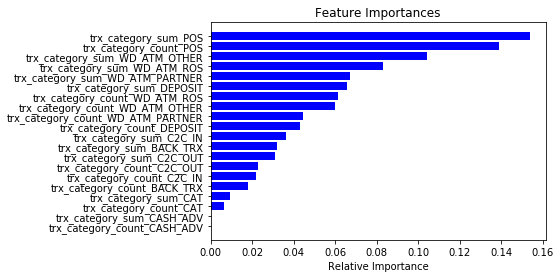

In [120]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Модельтолько ухудшилась. Идея оказалась плохой. Самыми важными показателями можно считать - trx_category_Pos 
#/ trx_category_WD_ATM_Other/trx_category_WD_ATM_ROS/ TRX_CAtegory_wd_atm_partner